In [9]:
# Segment Anything Image Segmentation examples using ONNX
#
# Before running this code, ensure that you used the export_onnx.ipynb notebook
# to export both SAM image encoder and SAM masks decoder to vit_b_encoder.onnx
# and vit_b_decoder.onnx.

In [ ]:
!pip install onnxruntime
!pip install Pillow
!pip install numpy

In [2]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from copy import deepcopy

In [11]:
# LOAD IMAGE
img = Image.open("cat_dog.jpg").convert("RGB")
img.size

(612, 415)

In [12]:
# 1. PREPROCESS IMAGE FOR ENCODER

# Resize image preserving aspect ratio using 1024 as a long side
orig_width, orig_height = img.size
resized_width, resized_height = img.size

if orig_width > orig_height:
    resized_width = 1024
    resized_height = int(1024 / orig_width * orig_height)
else:
    resized_height = 1024
    resized_width = int(1024 / orig_height * orig_width)

img = img.resize((resized_width, resized_height), Image.Resampling.BILINEAR)

img.size

(1024, 694)

In [13]:
# Prepare input tensor from image
input_tensor = np.array(img)

# Normalize input tensor numbers
mean = np.array([123.675, 116.28, 103.53])
std = np.array([[58.395, 57.12, 57.375]])
input_tensor = (input_tensor - mean) / std

# Transpose input tensor to shape (Batch,Channels,Height,Width
input_tensor = input_tensor.transpose(2,0,1)[None,:,:,:].astype(np.float32)

input_tensor.shape

(1, 3, 694, 1024)

In [14]:
# Make image square 1024x1024 by padding short side by zeros
if resized_height < resized_width:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,1024-resized_height),(0,0)))
else:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,0),(0,1024-resized_width)))

input_tensor.shape

(1, 3, 1024, 1024)

In [15]:
# 2. GET IMAGE EMBEDDINGS USING IMAGE ENCODER
encoder = ort.InferenceSession("vit_b_encoder.onnx")
outputs = encoder.run(None,{"images":input_tensor})
embeddings = outputs[0]

embeddings.shape

(1, 256, 64, 64)

In [ ]:
# 3. DECODE MASKS FROM IMAGE EMBEDDINGS

# 3.1 OPTION 1: Use single point as a prompt

In [16]:
# ENCODE PROMPT (single point)
input_point = np.array([[321,230]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])])[None, :].astype(np.float32)

coords = deepcopy(onnx_coord).astype(float)
coords[..., 0] = coords[..., 0] * (resized_width / orig_width)
coords[..., 1] = coords[..., 1] * (resized_height / orig_height)

onnx_coord = coords.astype("float32")
onnx_coord

array([[[537.098 , 384.6265],
        [  0.    ,   0.    ]]], dtype=float32)

In [17]:
# RUN DECODER TO GET MASK
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

decoder = ort.InferenceSession("vit_b_decoder.onnx")
masks,_,_ = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([orig_height, orig_width], dtype=np.float32)
})

In [37]:
# POSTPROCESS MASK
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255
mask.shape

(415, 612)

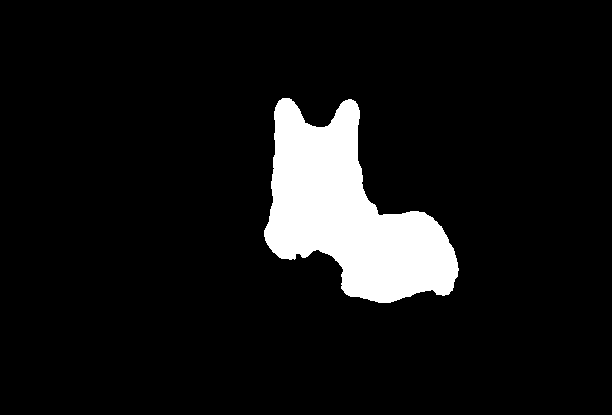

In [25]:
# VISUALIZE MASK
img_mask = Image.fromarray(mask,"L")
img_mask

In [ ]:
# 3.2 OPTION 2: Use box as a prompt

In [26]:
# ENCODE PROMPT (box)
input_box = np.array([132, 157, 256, 325]).reshape(2,2)
input_labels = np.array([2,3])

onnx_coord = input_box[None, :, :]
onnx_label = input_labels[None, :].astype(np.float32)

coords = deepcopy(onnx_coord).astype(float)
coords[..., 0] = coords[..., 0] * (resized_width / orig_width)
coords[..., 1] = coords[..., 1] * (resized_height / orig_height)

onnx_coord = coords.astype("float32")
onnx_coord

array([[[220.86275, 262.5494 ],
        [428.33987, 543.49396]]], dtype=float32)

In [27]:
# RUN DECODER TO GET MASK
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

decoder = ort.InferenceSession("vit_b_decoder.onnx")
masks,_,_ = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([orig_height, orig_width], dtype=np.float32)
})

In [36]:
# POSTPROCESS MASK
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255
mask.shape

(415, 612)

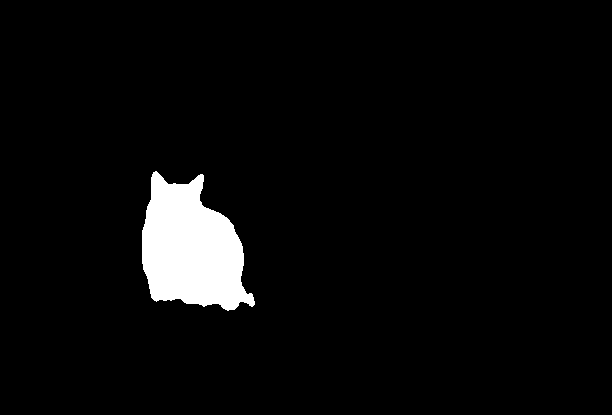

In [29]:
# VISUALIZE MASK
img_mask = Image.fromarray(mask, "L")
img_mask

In [ ]:
# 3.3 OPTION 3: Use box and point as a prompt

In [30]:
# ENCODE PROMPT (box)
input_box = np.array([132, 157, 256, 325]).reshape(2,2)
box_labels = np.array([2,3])
input_point = np.array([[140, 160]])
input_label = np.array([0])

onnx_coord = np.concatenate([input_point, input_box], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, box_labels], axis=0)[None, :].astype(np.float32)

coords = deepcopy(onnx_coord).astype(float)
coords[..., 0] = coords[..., 0] * (resized_width / orig_width)
coords[..., 1] = coords[..., 1] * (resized_height / orig_height)

onnx_coord = coords.astype("float32")
onnx_coord

array([[[234.24837, 267.56625],
        [220.86275, 262.5494 ],
        [428.33987, 543.49396]]], dtype=float32)

In [31]:
# RUN DECODER TO GET MASK
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

decoder = ort.InferenceSession("vit_b_decoder.onnx")
masks,_,_ = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([orig_height, orig_width], dtype=np.float32)
})

In [33]:
# POSTPROCESS MASK
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255
mask.shape

(415, 612)

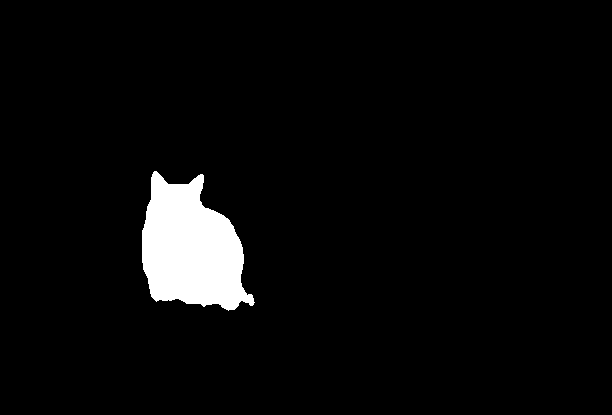

In [35]:
img_mask = Image.fromarray(mask, "L")
img_mask